In [1]:
import torch
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
from torch import nn

torch.cuda.is_available()

D:\deep_cel_shading\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [2]:
from typing import Tuple, Optional

import torch
from math import exp
import torch.nn.functional as F
from torch.autograd import Variable




def _psnr_compute(
    sum_squared_error: torch.Tensor,
    n_obs: int,
    data_range: float,
    base: float = 10.0,
    reduction: str = 'elementwise_mean',
) -> torch.Tensor:
    psnr_base_e = 2 * torch.log(data_range) - torch.log(sum_squared_error / n_obs)
    psnr = psnr_base_e * (10 / torch.log(torch.tensor(base)))
    return psnr


def _psnr_update(preds: torch.Tensor, target: torch.Tensor) -> Tuple[torch.Tensor, int]:
    sum_squared_error = torch.sum(torch.pow(preds - target, 2))
    n_obs = target.numel()
    return sum_squared_error, n_obs


def psnr(
    preds: torch.Tensor,
    target: torch.Tensor,
    data_range: Optional[float] = None,
    base: float = 10.0,
    reduction: str = 'elementwise_mean',
) -> torch.Tensor:
    """
    Computes the peak signal-to-noise ratio

    Args:
        preds: estimated signal
        target: groun truth signal
        data_range: the range of the data. If None, it is determined from the data (max - min)
        base: a base of a logarithm to use (default: 10)
        reduction: a method to reduce metric score over labels.

            - ``'elementwise_mean'``: takes the mean (default)
            - ``'sum'``: takes the sum
            - ``'none'``: no reduction will be applied
        return_state: returns a internal state that can be ddp reduced
            before doing the final calculation

    Return:
        Tensor with PSNR score

    Example:

        >>> pred = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
        >>> target = torch.tensor([[3.0, 2.0], [1.0, 0.0]])
        >>> psnr(pred, target)
        tensor(2.5527)

    """
    if data_range is None:
        data_range = target.max() - target.min()
    else:
        data_range = torch.tensor(float(data_range))
    sum_squared_error, n_obs = _psnr_update(preds, target)
    return _psnr_compute(sum_squared_error, n_obs, data_range, base, reduction)




In [29]:
from os import listdir
from os.path import isfile, join, isdir
import re

mypath = "res_compare"
dirs = [join(mypath, f) for f in listdir(mypath) if isdir(join(mypath, f))]

res = {}

trans = transforms.Compose([
    transforms.Resize([256, 256], transforms.InterpolationMode.BICUBIC), 
    transforms.ToTensor()
])

print(dirs)
for d in dirs:
    imgs = []
    for f in sorted(
        [join(d, f) for f in listdir(d) if isfile(join(d, f))], 
        key=lambda x: int(re.search(r'\d+', x.split("\\")[-1]).group())
    ):
        if "_real" in f:
            continue
        
        #print(f.split("\\")[-1])
        #print(int(re.search(r'\d', f).group()))
        
        img = Image.open(f).convert('RGB')

        if "truth" in d:
            w, h = img.size
            w2 = int(w / 2)
            A = img.crop((0, 0, w2, h))
            B = img.crop((w2, 0, w, h))
            
            imgs.append(trans(B))
        else:
            imgs.append(trans(img))
        
    res[d.split("\\")[1]] = imgs
    

['res_compare\\Default Pix2Pix', 'res_compare\\NST ResNet', 'res_compare\\NST VGG', 'res_compare\\Pix2Pix Perceptual Loss', 'res_compare\\Pix2Pix Perceptual Loss Upscaled', 'res_compare\\Pix2Pix Upscaled', 'res_compare\\SSIM', 'res_compare\\SSIM Upscaled', 'res_compare\\truth', 'res_compare\\_Pix2Pix Downscaled']


In [13]:
res['Pix2Pix Upscaled'][3].shape

torch.Size([3, 128, 128])

In [138]:
c = 1
for i in res['Default Pix2Pix']:
    transforms.ToPILImage()(i).save('res_compare/_Pix2Pix Downscaled/{}.jpg'.format(c))
    c = c + 1

In [130]:
import os

for d in dirs:
    imgs = []
    for f in sorted(
        [join(d, f) for f in listdir(d) if isfile(join(d, f))], 
        key=lambda x: int(re.search(r'\d+', x.split("\\")[-1]).group())
    ):
        if "_real" in f:
            os.remove(f)

In [4]:
import importlib


class VggLoss(nn.Module):
    def __init__(self, name):
        super(VggLoss, self).__init__()
        #print("Loading VGG19 model from path: {}".format(model_paths["vgg"]))

        vgg_name = f"torchvision.models.vgg"
        print(f"vgg name {name}")
        lib = importlib.import_module(vgg_name)
        for lname, cls in lib.__dict__.items():
            if lname.lower() == name.lower():
                vgg = cls()

        state_dict = torch.load(f'./pytorch-CycleGAN-and-pix2pix/checkpoints/{name}.pth')
        vgg.load_state_dict(state_dict)

        self.vgg_model = torch.nn.Sequential(*(list(vgg.children())[:-1]))
        #self.vgg_model.load_state_dict(torch.load(model_paths['vgg']))
        self.vgg_model.cuda()
        self.vgg_model.eval()

        self.l1loss = torch.nn.L1Loss()

    def forward(self, input_photo, output):
        vgg_photo = self.vgg_model(input_photo)
        vgg_output = self.vgg_model(output)
        #n, c, h, w = vgg_photo.shape
        # h, w, c = vgg_photo.get_shape().as_list()[1:]
        loss = self.l1loss(vgg_photo, vgg_output)

        return loss

In [30]:
from IPython.display import display
import ssim

target = res['truth']

print(ssim.ssim)

vgg_loss = VggLoss('vgg11')

losses_fn = { 
    "L1": torch.nn.L1Loss(), 
    "PSNR": psnr, 
    "SSIM": lambda x, y: ssim.ssim(x.unsqueeze(1), y.unsqueeze(1), data_range=1.0, size_average=False, win_size=9).mean(),
    "VGG": lambda x, y: vgg_loss(x.cuda(), y.cuda()).detach()
}

results = {}

for d in res.keys():
    print(d)
    losses = {}

    for l in losses_fn.keys():
        r = []
        loss = losses_fn[l]
        for i, t in zip(res[d], target):
            r.append(loss(i, t))
            #display(transforms.ToPILImage()(t))
            #display(transforms.ToPILImage()(i))
            #print("123")
            
        losses[l] = r
    results[d] = losses
        

<function ssim at 0x000001BF8CC30DC0>
vgg name vgg11
Default Pix2Pix
NST ResNet
NST VGG
Pix2Pix Perceptual Loss
Pix2Pix Perceptual Loss Upscaled
Pix2Pix Upscaled
SSIM
SSIM Upscaled
truth
_Pix2Pix Downscaled


In [31]:
print(results['SSIM'])

{'L1': [tensor(0.0508), tensor(0.0582), tensor(0.0423), tensor(0.0302), tensor(0.0346), tensor(0.0356), tensor(0.0575), tensor(0.0435), tensor(0.0331), tensor(0.0504), tensor(0.0442), tensor(0.0423), tensor(0.0517), tensor(0.0582), tensor(0.0430), tensor(0.0289), tensor(0.0362), tensor(0.0277), tensor(0.0307), tensor(0.0342), tensor(0.0207), tensor(0.0238), tensor(0.0233), tensor(0.0178), tensor(0.0217), tensor(0.0284), tensor(0.0258), tensor(0.0286), tensor(0.0643)], 'PSNR': [tensor(22.7155), tensor(21.5530), tensor(24.0460), tensor(25.9662), tensor(25.3144), tensor(24.2435), tensor(22.0274), tensor(21.2349), tensor(23.1970), tensor(21.3940), tensor(23.1741), tensor(24.2597), tensor(22.5908), tensor(21.5374), tensor(23.8782), tensor(25.4831), tensor(24.7020), tensor(26.4677), tensor(26.2322), tensor(24.9030), tensor(27.9308), tensor(28.1714), tensor(28.0730), tensor(30.5387), tensor(28.5130), tensor(26.9168), tensor(27.2428), tensor(25.5141), tensor(20.8495)], 'SSIM': [tensor(0.8490),

In [32]:
means = {}
labels = []

for r in results.keys():
    if "truth" in r or "_" in r:
        continue
    
    labels.append(r)
    for l in results[r].keys():
        loss = results[r][l]
        if l not in means:
            means[l] = []
            

        loss = torch.stack(loss).cpu()
        #print(loss)
        means[l].append(np.mean(np.array(loss)))
    
print(means)

{'L1': [0.028349355, 0.25333112, 0.13313696, 0.040162586, 0.040323403, 0.034089375, 0.037506193, 0.038864292], 'PSNR': [27.329699, 10.747139, 15.071328, 24.59983, 24.318298, 25.307133, 24.781725, 24.224812], 'SSIM': [0.9155061, 0.54776156, 0.6811931, 0.8829816, 0.88222337, 0.89568484, 0.88278437, 0.88297635], 'VGG': [0.061294712, 0.13878636, 0.13843045, 0.10525788, 0.095157996, 0.08275563, 0.10845987, 0.09386057]}


<BarContainer object of 8 artists>

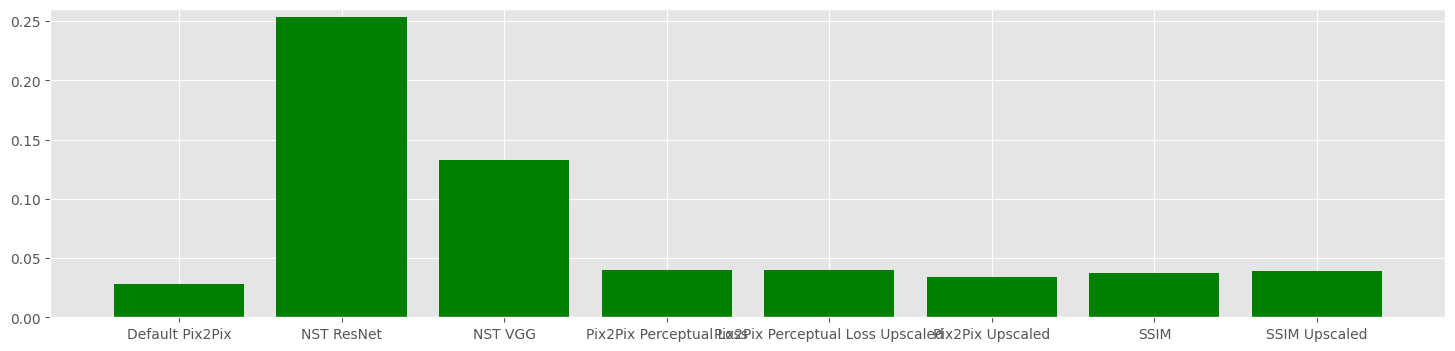

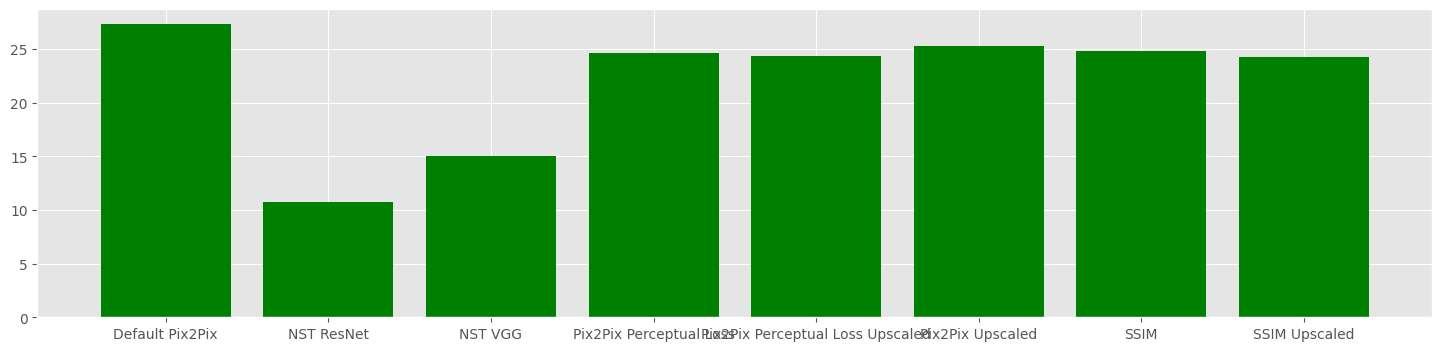

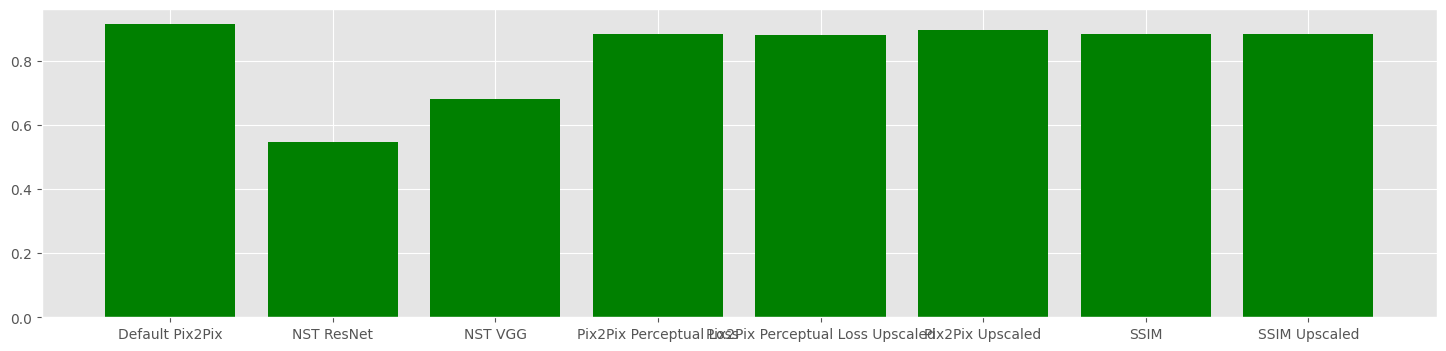

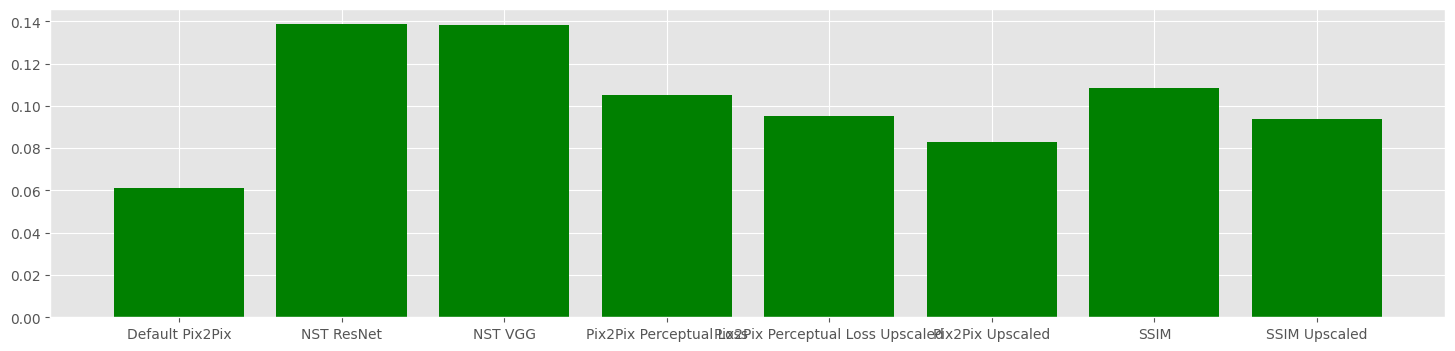

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(18,4))

plt.style.use('ggplot')

plt.ylim(0.0, 0.26)

plt.bar(labels, means['L1'], color='green')

fig, ax = plt.subplots(figsize=(18,4))
plt.bar(labels, means['PSNR'], color='green')

fig, ax = plt.subplots(figsize=(18,4))
#plt.ylim(0.999, 1)
plt.bar(labels, means['SSIM'], color='green')

fig, ax = plt.subplots(figsize=(18,4))
#plt.ylim(0.999, 1)
plt.bar(labels, means['VGG'], color='green')

In [34]:
import json

m = {}

for r in results.keys():
    if "truth" in r or "_" in r:
        continue
    
    labels.append(r)
    for l in results[r].keys():
        loss = results[r][l]
        if l not in m:
            m[l] = []
            

        loss = torch.stack(loss).cpu()
        #print(loss)
        m[l].append(float(np.mean(np.array(loss))))
        
json.dumps(labels)

'["Default Pix2Pix", "NST ResNet", "NST VGG", "Pix2Pix Perceptual Loss", "Pix2Pix Perceptual Loss Upscaled", "Pix2Pix Upscaled", "SSIM", "SSIM Upscaled", "Default Pix2Pix", "NST ResNet", "NST VGG", "Pix2Pix Perceptual Loss", "Pix2Pix Perceptual Loss Upscaled", "Pix2Pix Upscaled", "SSIM", "SSIM Upscaled"]'

In [36]:
d = 'test_ds'
for f in sorted(
    [join(d, f) for f in listdir(d) if isfile(join(d, f))], 
    key=lambda x: int(re.search(r'\d+', x.split("\\")[-1]).group())
):
    if "_real" in f:
        continue

    #print(f.split("\\")[-1])
    #print(int(re.search(r'\d', f).group()))

    img = Image.open(f).convert('RGB')


    w, h = img.size
    w2 = int(w / 2)
    A = img.crop((0, 0, w2, h))
    B = img.crop((w2, 0, w, h))
    
    ind = int(re.search(r'\d+', f.split("\\")[-1]).group())
    
    A.save('test_ds\{}_in.jpg'.format(ind))
    B.save('test_ds\{}_out.jpg'.format(ind))

In [48]:
out = "Method & "

for k in results[list(results.keys())[0]].keys():
    if "truth" in k or "_" in k:
        continue
    out += k + " & "
out += "\\\\ \n"
    
c = 0
for l in labels:
    out += l + " & "
    for v in results[l].values():
        if "truth" in v or "_" in v:
            continue
        out += "{:.4f}".format(v[c]) + " & "
    c += 1
    out += "\\\\ \n"

print(out)

Method & L1 & PSNR & SSIM & VGG & \\ 
Default Pix2Pix & 0.0382 & 24.4062 & 0.8886 & 0.0819 & \\ 
NST ResNet & 0.1653 & 13.1009 & 0.4627 & 0.1531 & \\ 
NST VGG & 0.1349 & 14.8963 & 0.6836 & 0.1439 & \\ 
Pix2Pix Perceptual Loss & 0.0295 & 26.0810 & 0.9028 & 0.0964 & \\ 
Pix2Pix Perceptual Loss Upscaled & 0.0343 & 25.0318 & 0.8891 & 0.0803 & \\ 
Pix2Pix Upscaled & 0.0286 & 25.3972 & 0.8938 & 0.0758 & \\ 
SSIM & 0.0575 & 22.0274 & 0.8542 & 0.1174 & \\ 
SSIM Upscaled & 0.0437 & 20.8119 & 0.8861 & 0.0995 & \\ 
Default Pix2Pix & 0.0252 & 23.5496 & 0.9113 & 0.0714 & \\ 
NST ResNet & 0.1075 & 16.1919 & 0.5150 & 0.1692 & \\ 
NST VGG & 0.1423 & 14.5171 & 0.6571 & 0.1569 & \\ 
Pix2Pix Perceptual Loss & 0.0439 & 23.9081 & 0.8751 & 0.1084 & \\ 
Pix2Pix Perceptual Loss Upscaled & 0.0534 & 22.4968 & 0.8436 & 0.1131 & \\ 
Pix2Pix Upscaled & 0.0574 & 21.5014 & 0.8681 & 0.0961 & \\ 
SSIM & 0.0430 & 23.8782 & 0.8658 & 0.1070 & \\ 
SSIM Upscaled & 0.0295 & 25.0728 & 0.8952 & 0.0852 & \\ 

